# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

**Credits**  
The parallel implementation here is based on this paper: Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). Parallelized stochastic gradient descent. Advances in Neural …, 1–36. Retrieved from http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent 

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, effective_rank=effective_rank)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    pass

In [6]:
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

## SciKit-Learn SGD

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
n_iter = 5000

In [9]:
sgd = SGDRegressor(n_iter=n_iter)

In [10]:
%time sgd.fit(X_train, y_train)

CPU times: user 1.16 s, sys: 18.7 ms, total: 1.18 s
Wall time: 1.16 s


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [11]:
sgd.score(X_test, y_test)

0.76599418431691113

Train iteratively so get score at each iteration:

In [12]:
scores_base = []
sgd = SGDRegressor(n_iter=1, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores_base += [sgd.score(X_test, y_test)]

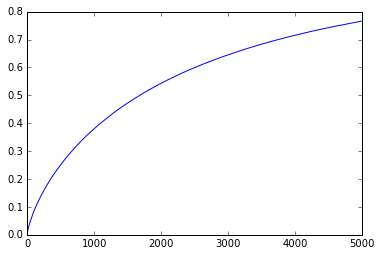

In [13]:
plt.plot(range(len(scores_base)), scores_base)

In [16]:
scores_base[-1]

0.76599026695742145

## Parallel SGD
Parallel implementation of SGD based on the simulation results from previous section

In [32]:
from multiprocessing import Pool
import time
import math

In [18]:
reload(utils)

<module 'utils' from 'utils.pyc'>

### Performance with reduced iterations per worker
`n_iter = 5000/n_jobs`

In [19]:
parallel_data_reduced = []

for n_jobs in range(1, 9):
    for n_sync in range(1, 9):
        n_iter = 5000/n_jobs
        data = utils.split_data(X_train, y_train, n_jobs, 1, True)
        pool = Pool(processes=n_jobs)
        
        start_time = time.time()
        sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)
        seconds = time.time() - start_time
        
        parallel_data_reduced += [(n_jobs, n_iter, n_sync, sgd.score(X_test, y_test), seconds)]

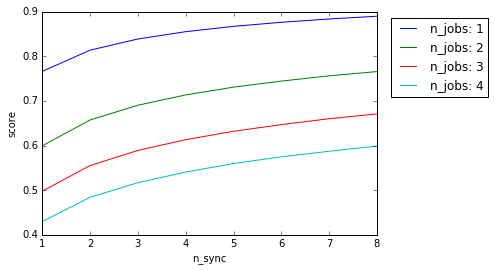

In [20]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[3] for x in parallel_data_reduced[i*8:(i+1)*8]]
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("score")

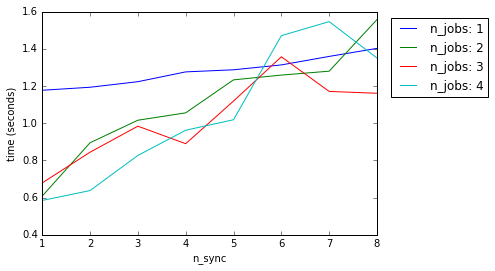

In [21]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[4] for x in parallel_data_reduced[i*8:(i+1)*8]]
#     print points
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("time (seconds)")

### Performance with all iterations per worker
`n_iter = 5000`

In [23]:
parallel_data_full = []

for n_jobs in range(1, 9):
    for n_sync in range(1, 9):
        n_iter = 5000
        data = utils.split_data(X_train, y_train, n_jobs, 1, True)
        pool = Pool(processes=n_jobs)
        
        start_time = time.time()
        sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)
        seconds = time.time() - start_time
        
        parallel_data_full += [(n_jobs, n_iter, n_sync, sgd.score(X_test, y_test), seconds)]

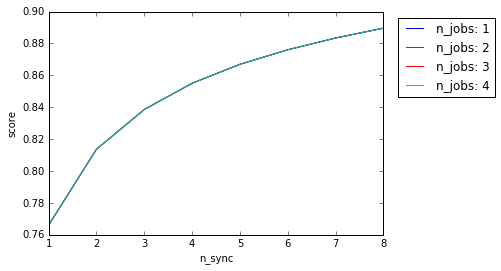

In [24]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[3] for x in parallel_data_full[i*8:(i+1)*8]]
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("score")

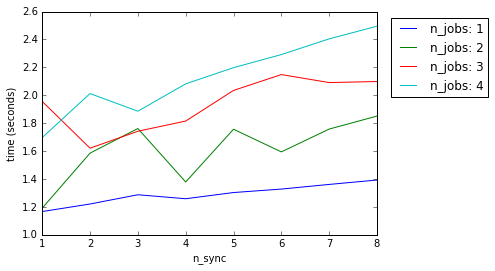

In [25]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[4] for x in parallel_data_full[i*8:(i+1)*8]]
#     print points
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("time (seconds)")

### Performance with fractional iterations per worker
`n_iter = 5000 / math.ceil(n_jobs * 0.5)`

In [33]:
parallel_data_frac = []

for n_jobs in range(1, 5):
    for n_sync in range(1, 9):
        n_iter = 5000/math.ceil(n_jobs*0.5)
        data = utils.split_data(X_train, y_train, n_jobs, 1, True)
        pool = Pool(processes=n_jobs)
        
        start_time = time.time()
        sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)
        seconds = time.time() - start_time
        
        parallel_data_frac += [(n_jobs, n_iter, n_sync, sgd.score(X_test, y_test), seconds)]

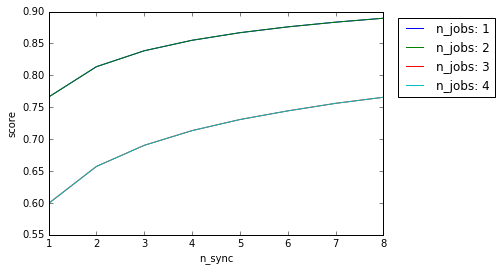

In [43]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[3] for x in parallel_data_frac[i*8:(i+1)*8]]
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("score")

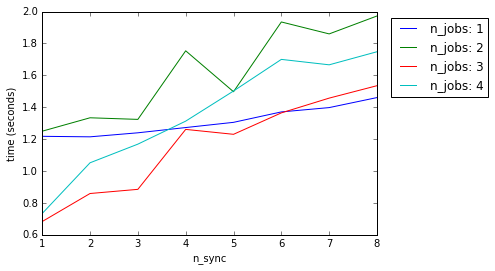

In [35]:
plt.figure(1)
legend = []
for i in range(4):
    points = [x[4] for x in parallel_data_frac[i*8:(i+1)*8]]
#     print points
    plt.plot(range(1,9), points)
    legend += ["n_jobs: "+str(i+1)]
plt.legend(legend, bbox_to_anchor=(1.35, 1))
plt.xlabel("n_sync")
plt.ylabel("time (seconds)")